## Imports

In [1]:
%load_ext autoreload
%autoreload 

%matplotlib inline

In [2]:
from fastai.imports import *
from fastai.structured import *
from pandas_summary import DataFrameSummary
from IPython.display import display

from matplotlib import pyplot as plt
import seaborn as sns
sns.set(style="white", palette="colorblind", font_scale=1.2, 
        rc={"figure.figsize":(12,9)})
import plotly.graph_objs as go
from plotly import tools
import plotly.plotly as py
import plotly.figure_factory as ff
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

import numpy as np
from pandas.api.types import is_string_dtype, is_numeric_dtype
import os
import sys
import time

from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

import eli5
from eli5.sklearn import PermutationImportance
from concurrent.futures import ProcessPoolExecutor

from scipy.cluster import hierarchy as hc
from pdpbox import pdp

RANDOM_STATE = 42

## Helper functions

In [36]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)
        
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

def print_score(m):    
    y_t_pred = m.predict_proba(X_train)    
    y_t_pred = y_t_pred if y_t_pred.ndim == 1 else y_t_pred[:, 1]
    
    
    y_v_pred = m.predict_proba(X_valid)    
    y_v_pred = y_v_pred if y_v_pred.ndim == 1 else y_v_pred[:, 1]
    
    res = [roc_auc_score(y_train, y_t_pred), roc_auc_score(y_valid, y_v_pred)]
    print(res)

def add_datepart(df, fldname, drop=True, time=False, errors="raise"):   
    """add_datepart converts a column of df from a datetime64 to many columns containing
    the information from the date. This applies changes inplace.
    Parameters:
    -----------
    df: A pandas data frame. df gain several new columns.
    fldname: A string that is the name of the date column you wish to expand.
        If it is not a datetime64 series, it will be converted to one with pd.to_datetime.
    drop: If true then the original date column will be removed.
    time: If true time features: Hour, Minute, Second will be added.    
    """
    fld = df[fldname]
    fld_dtype = fld.dtype
    if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
        fld_dtype = np.datetime64

    if not np.issubdtype(fld_dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True, errors=errors)
    targ_pre = re.sub('[Dd]ate$', '', fldname)
    attr = ['Year', 'Month', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
    if time: attr = attr + ['Hour', 'Minute', 'Second']
    for n in attr: df[targ_pre + n] = getattr(fld.dt, n.lower())
    df[targ_pre + 'Elapsed'] = fld.astype(np.int64) // 10 ** 9
    if drop: df.drop(fldname, axis=1, inplace=True)
        
def plot_numerical(data, feature, figsize=(16, 5)):
    """ helper function for visualization using Seaborn  """
    data = data[~data[feature].isnull()]
    grouped = data[[feature, 'late_loan']].groupby(feature)
    mean = grouped.mean().reset_index()
    hist_kws={'histtype': 'bar', 'edgecolor':'black', 'alpha': 0.2}
    warnings.filterwarnings('ignore')

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=figsize)
    sns.distplot(data[data['late_loan'] == 0][feature], label='Late Loan: 0',
                 ax=ax[0], hist_kws=hist_kws)
    sns.distplot(data[data['late_loan'] == 1][feature], label='Late Loan: 1',
                 ax=ax[0], hist_kws=hist_kws)
    ax[0].legend()
    ax[1].plot(mean[feature], mean['late_loan'], '.:', alpha=0.5)
    ax[1].set_xlabel(feature)
    ax[1].set_ylabel('Mean')
    ax[1].grid(True)
    plt.tight_layout()
    return fig, ax

In [4]:
PATH = "data/"
!ls {PATH}

'20190325 - data science exercise - data description.txt'   IndoorMovement
'20190325 - data science exercise.xlsx'			    loan.csv
 bulldozers


## Quick look at the data

In [5]:
parse_dates = ["issue_d", "last_pymnt_d", "next_pymnt_d", "payment_plan_start_date",
              "hardship_start_date", "hardship_end_date","debt_settlement_flag_date", "settlement_date"]
df_raw = pd.read_csv(f'{PATH}loan.csv', low_memory=False, parse_dates=parse_dates)

In [7]:
display_all(df_raw.tail().T)

,2260663,2260664,2260665,2260666,2260667
id,NaN,NaN,NaN,NaN,NaN
member_id,NaN,NaN,NaN,NaN,NaN
loan_amnt,12000,12000,10000,12000,16550
funded_amnt,12000,12000,10000,12000,16550
funded_amnt_inv,12000,12000,10000,12000,16550
term,60 months,60 months,36 months,60 months,60 months
int_rate,14.08,25.82,11.99,21.45,21.45
installment,279.72,358.01,332.1,327.69,451.94
grade,C,E,B,D,D
sub_grade,C3,E4,B5,D5,D5


In [8]:
display_all(df_raw.describe(include='all').T)

,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
id,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
member_id,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
loan_amnt,2.26067e+06,NaN,NaN,NaN,NaN,NaN,15046.9,9190.25,500,8000,12900,20000,40000
funded_amnt,2.26067e+06,NaN,NaN,NaN,NaN,NaN,15041.7,9188.41,500,8000,12875,20000,40000
funded_amnt_inv,2.26067e+06,NaN,NaN,NaN,NaN,NaN,15023.4,9192.33,0,8000,12800,20000,40000
term,2260668,2,36 months,1609754,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
int_rate,2.26067e+06,NaN,NaN,NaN,NaN,NaN,13.0929,4.83211,5.31,9.49,12.62,15.99,30.99
installment,2.26067e+06,NaN,NaN,NaN,NaN,NaN,445.808,267.174,4.93,251.65,377.99,593.32,1719.83
grade,2260668,7,B,663557,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sub_grade,2260668,35,C1,145903,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Define a late loan

#### Add date part

First, we need to converts all columns of df_raw from datetime64 to many columns containing the information from the date

In [9]:
for cols in parse_dates:
    add_datepart(df_raw, cols)

Now, let's look at the status of loans

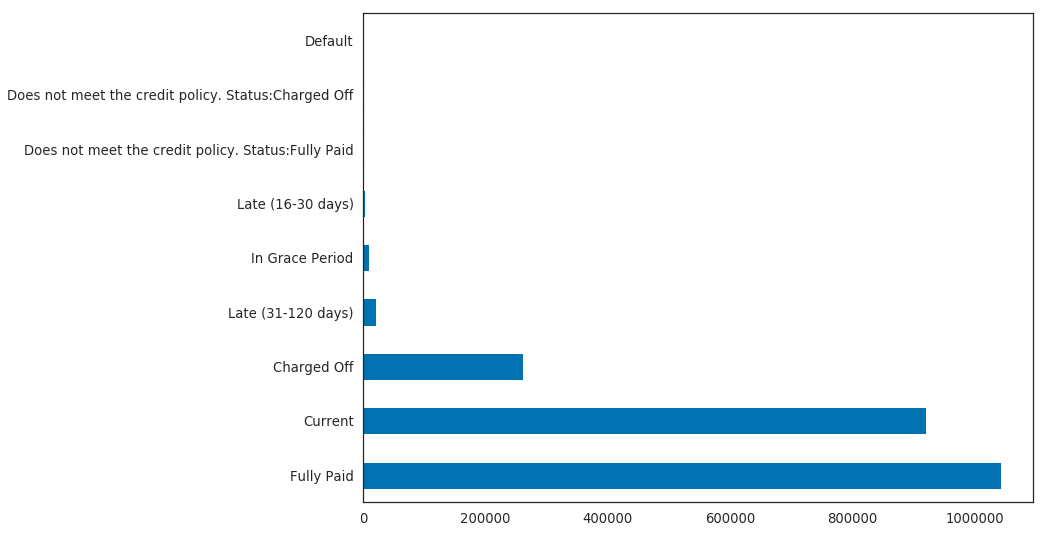

In [10]:
df_raw["loan_status"].value_counts().plot.barh();

Based on information from https://help.lendingclub.com/hc/en-us/articles/215488038, loans with status of Charged Off, Default, Does not meet the credit policy. Status:Charged Off, In Grace Period, Late (16-30 days), and Late (31-120 days) are defined as late loans.

In [11]:
late_loan_status = ["Charged Off", "Default", "Does not meet the credit policy. Status:Charged Off", 
                    "In Grace Period", "Late (16-30 days)", "Late (31-120 days)"]

def is_late_loan(loan_status):
    if loan_status in late_loan_status:
        return True
    else:
        return False    
    
df_raw['late_loan'] = df_raw['loan_status'].apply(is_late_loan)

df_raw.drop(['id', 'member_id', 'emp_title', 'url', 'desc', 'zip_code', 'title', 'loan_status'], axis=1, inplace=True)

[Text(0, 0.5, '(%)')]

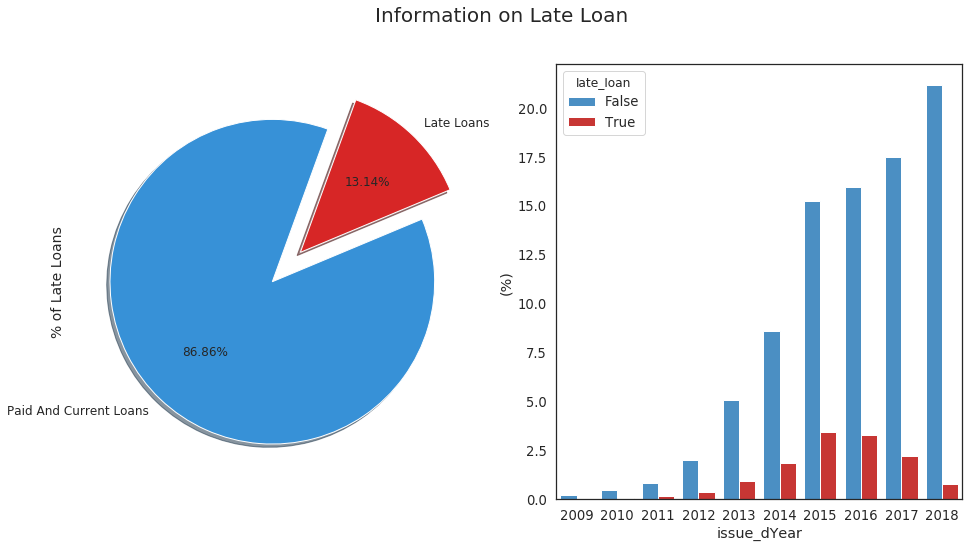

In [12]:
f, ax = plt.subplots(1,2, figsize=(16,8))

colors = ["#3791D7", "#D72626"]
labels = ["Paid And Current Loans", "Late Loans"]

plt.suptitle('Information on Late Loan', fontsize=20)
df_raw["late_loan"].value_counts().plot.pie(explode=[0,0.25], autopct='%1.2f%%', ax=ax[0], shadow=True, 
                                            colors=colors, labels=labels, fontsize=12, startangle=70)


df_2009 = df_raw[df_raw["issue_dYear"]>=2009]
ax[0].set_ylabel('% of Late Loans', fontsize=14)

palette = ["#3791D7", "#E01E1B"]
sns.barplot(x="issue_dYear", y="loan_amnt", hue="late_loan", data=df_2009, 
            estimator=lambda x: len(x) / len(df_2009) * 100, palette=palette)
ax[1].set(ylabel="(%)")

## Initial processing

We call here train_cats to convert strings to pandas categories.

In [13]:
train_cats(df_raw)

In [14]:
display_all(df_raw.isnull().sum().sort_index()/len(df_raw))

acc_now_delinq                                0.000013
acc_open_past_24mths                          0.022131
addr_state                                    0.000000
all_util                                      0.383227
annual_inc                                    0.000002
annual_inc_joint                              0.946604
application_type                              0.000000
avg_cur_bal                                   0.031117
bc_open_to_buy                                0.033147
bc_util                                       0.033650
chargeoff_within_12_mths                      0.000064
collection_recovery_fee                       0.000000
collections_12_mths_ex_med                    0.000064
debt_settlement_flag                          0.000000
debt_settlement_flag_Elapsed                  0.000000
debt_settlement_flag_Is_quarter_end           0.000000
debt_settlement_flag_Is_quarter_start         0.000000
debt_settlement_flag_Is_year_end              0.000000
debt_settl

 Save this file for now so that we can access efficient.

In [ ]:
os.makedirs('tmp', exist_ok=True)
df_raw.to_feather('tmp/loan-raw')

## Processing

In the future we can simply read it from this fast format.

In [6]:
df_raw = pd.read_feather('tmp/loan-raw')

We'll replace categories with their numeric codes, handle missing continuous values, and split the dependent variable into a separate variable.

In [15]:
df, y, nas = proc_df(df_raw, 'late_loan', max_n_cat=7)

## Feature importance

For model interpretation, there's no need to use the full dataset on each tree - using a subset will be both faster, and also provide better interpretability (since an overfit model will not provide much variance across trees).

In [16]:
X_train, X_valid, y_train, y_valid = train_test_split(df, y, test_size=0.33, random_state=RANDOM_STATE)

In [17]:
set_rf_samples(50000)

In [18]:
m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1)
m.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=0.5, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [19]:
print_score(m)

[0.9979336152255835, 0.995601825644827]


In [20]:
fi = rf_feat_importance(m, X_train); fi[:10]

,cols,imp
28,recoveries,0.379460
29,collection_recovery_fee,0.170567
25,total_rec_prncp,0.085737
1,funded_amnt,0.052610
0,loan_amnt,0.032772
127,last_pymnt_dElapsed,0.028449
30,last_pymnt_amnt,0.018615
2,funded_amnt_inv,0.018615
120,issue_dElapsed,0.016145
4,installment,0.014081


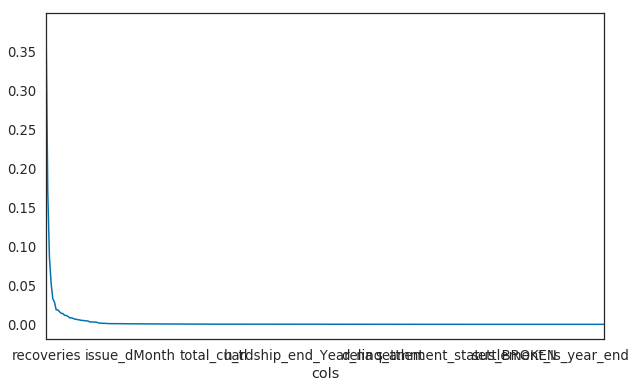

In [21]:
fi.plot('cols', 'imp', figsize=(10,6), legend=False);

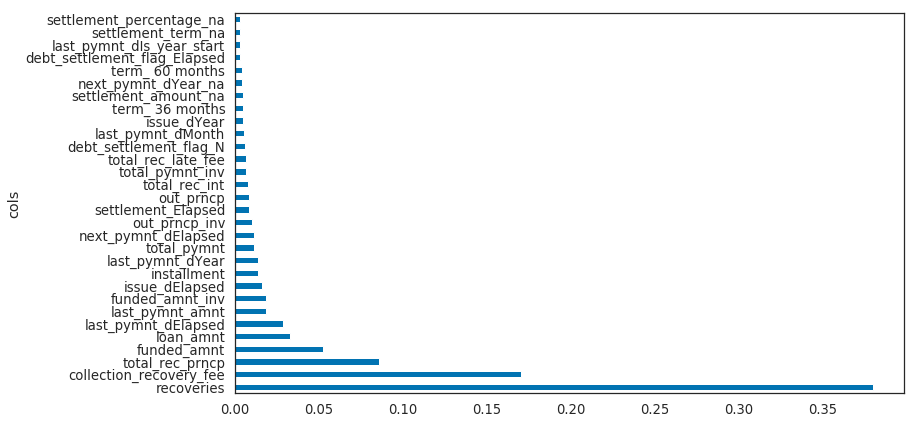

In [22]:
plot_fi(fi[:30]);

In [23]:
features = list(X_train.columns)

feat_imp_df = eli5.explain_weights_df(m, feature_names=features)
feat_imp_df.head(10)

,feature,weight,std
0,recoveries,0.379460,0.248564
1,collection_recovery_fee,0.170567,0.247519
2,total_rec_prncp,0.085737,0.027710
3,funded_amnt,0.052610,0.053009
4,loan_amnt,0.032772,0.037196
5,last_pymnt_dElapsed,0.028449,0.026897
6,last_pymnt_amnt,0.018615,0.012501
7,funded_amnt_inv,0.018615,0.021312
8,issue_dElapsed,0.016145,0.024765
9,installment,0.014081,0.018862


In [24]:
top = list(eli5.explain_weights_df(m, feature_names=features).head(10).feature)

Let's keep only top important features and do RF again

In [25]:
to_keep = fi[fi.imp>0.005].cols; len(to_keep)

22

In [26]:
df_keep = df[to_keep].copy()
X_train, X_valid, y_train, y_valid = train_test_split(df_keep, y, test_size=0.33, random_state=42)

In [27]:
m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1)
m.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=0.5, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [28]:
print_score(m)

[0.9983965033175457, 0.9962347025873828]


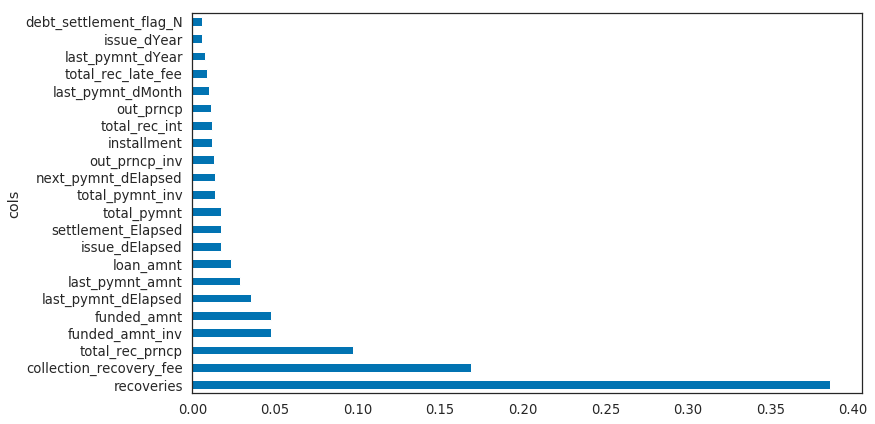

In [29]:
fi = rf_feat_importance(m, df_keep)
plot_fi(fi);

### Redundant features

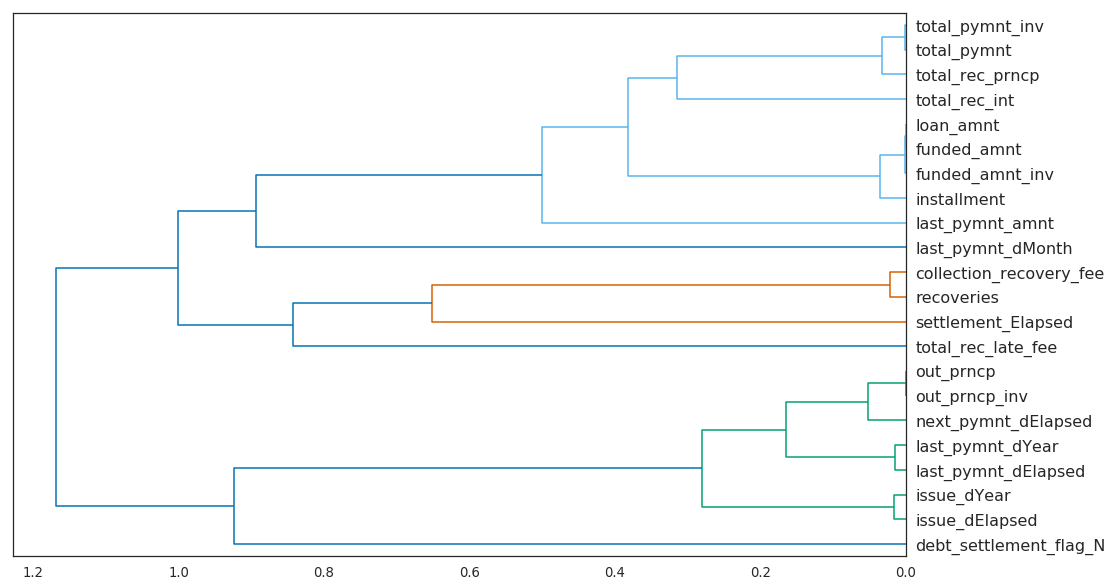

In [30]:
corr = np.round(scipy.stats.spearmanr(df_keep).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=df_keep.columns, orientation='left', leaf_font_size=16)
plt.show()

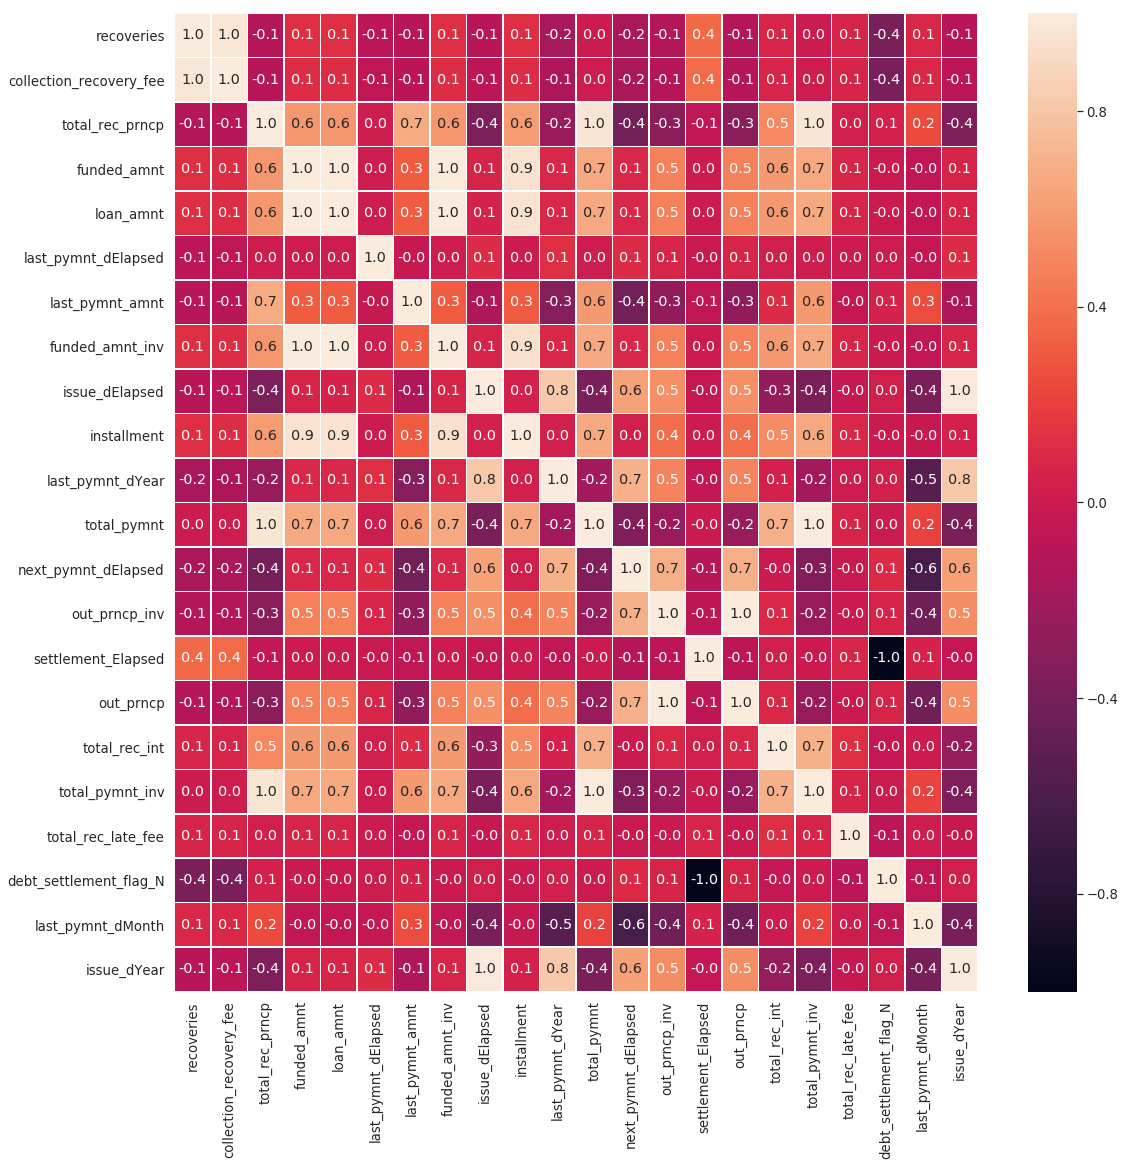

In [31]:
f,ax = plt.subplots(figsize=(18, 18))
sns.heatmap(df_keep.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)

### How do features contribute to predictions?

In [32]:
features = list(X_train.columns)

In [33]:
train_expl_list = [eli5.explain_prediction_df(m, X_train.loc[i], feature_names=features) for i in X_train.index[:100]]

In [34]:
keys = [f'Loan #{i}' for i in X_train.index[:100]]
train_expl_df = pd.concat(train_expl_list, keys=keys, names=['Loans'])

train_expl_df

target                  feature    weight         value
Loans                                                                    
Loan #329532  0    False                   <BIAS>  0.868890  1.000000e+00
              1    False      last_pymnt_dElapsed  0.050111  1.548979e+09
              2    False               recoveries  0.043121  0.000000e+00
              3    False  collection_recovery_fee  0.020293  0.000000e+00
              4    False        last_pymnt_dMonth  0.005296  2.000000e+00
              5    False         last_pymnt_dYear  0.004640  2.019000e+03
              6    False       total_rec_late_fee  0.004515  0.000000e+00
              7    False      next_pymnt_dElapsed  0.004007  1.551398e+09
              8    False       settlement_Elapsed  0.002031 -9.223372e+09
              9    False            total_rec_int  0.001535  4.452600e+02
              10   False            out_prncp_inv  0.001315  6.934520e+03
              11   False              total_pymnt  0.000706  2.510740e+03
              12   False   debt_settlement_flag_N  0.000698  1.000000e+00
              13   False          total_pymnt_inv  0.000346  2.510740e+03
              14   False              installment  0.000313  2.798000e+02
              15   False                out_prncp  0.000143  6.934520e+03
              16   False              issue_dYear  0.000129  2.018000e+03
              17   False          funded_amnt_inv  0.000086  9.000000e+03
              18   False                loan_amnt  0.000058  9.000000e+03
              19   False              funded_amnt  0.000018  9.000000e+03
              20   False           issue_dElapsed -0.000145  1.525133e+09
              21   False          total_rec_prncp -0.002946  2.065480e+03
              22   False          last_pymnt_amnt -0.005160  2.798000e+02
Loan #1558770 0    False                   <BIAS>  0.868890  1.000000e+00
              1    False      last_pymnt_dElapsed  0.050111  1.548979e+09
              2    False               recoveries  0.043121  0.000000e+00
              3    False  collection_recovery_fee  0.020293  0.000000e+00
              4    False        last_pymnt_dMonth  0.005296  2.000000e+00
              5    False         last_pymnt_dYear  0.004640  2.019000e+03
              6    False       total_rec_late_fee  0.004629  0.000000e+00
...                  ...                      ...       ...           ...
Loan #1854927 15   False          total_pymnt_inv  0.001295  1.041044e+04
              16   False   debt_settlement_flag_N  0.000856  1.000000e+00
              17   False      next_pymnt_dElapsed -0.001076 -9.223372e+09
              18   False        last_pymnt_dMonth -0.001411  4.000000e+00
              19   False         last_pymnt_dYear -0.008933  2.015000e+03
              20   False              total_pymnt -0.012859  1.041044e+04
              21   False      last_pymnt_dElapsed -0.044520  1.427846e+09
              22   False          last_pymnt_amnt -0.071887  2.970000e+02
Loan #1202105 0    False                   <BIAS>  0.868890  1.000000e+00
              1    False               recoveries  0.054668  0.000000e+00
              2    False          last_pymnt_amnt  0.046783  3.167120e+03
              3    False          total_rec_prncp  0.024704  9.550000e+03
              4    False  collection_recovery_fee  0.023249  0.000000e+00
              5    False      next_pymnt_dElapsed  0.003165 -9.223372e+09
              6    False       settlement_Elapsed  0.002190 -9.223372e+09
              7    False                out_prncp  0.002118  0.000000e+00
              8    False       total_rec_late_fee  0.002107  0.000000e+00
              9    False            out_prncp_inv  0.001939  0.000000e+00
              10   False              total_pymnt  0.001679  1.184076e+04
              11   False            total_rec_int  0.001047  2.290760e+03
              12   False          total_pymnt_inv  0.000791  1.184076e+04
              13   Fal

In [35]:
valid_expl_list = [eli5.explain_prediction_df(m, X_valid.loc[i], feature_names=features) for i in X_valid.index[:100]]
keys = [f'Loan #{i}' for i in X_valid.index[:100]]
valid_expl_df = pd.concat(valid_expl_list, keys=keys, names=['Loans'])

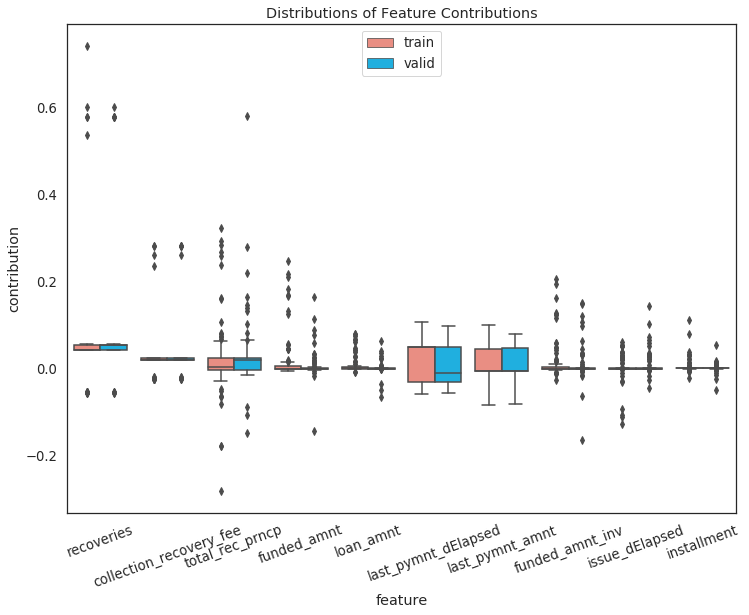

In [37]:
train_expl_df.rename(columns={'weight': 'contribution'}, inplace=True)
valid_expl_df.rename(columns={'weight': 'contribution'}, inplace=True)

train_expl_df['data'] = 'train'
valid_expl_df['data'] = 'valid'

train_valid_expl_df = pd.concat([train_expl_df, valid_expl_df])

sns.boxplot(x='feature', y='contribution', hue='data', order=top,
            data=train_valid_expl_df.loc[train_valid_expl_df.feature.isin(top)],
            palette={'train': 'salmon', 
                     'valid':'deepskyblue'})
plt.legend(loc=9)
plt.title('Distributions of Feature Contributions')
plt.xticks(rotation=20);

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

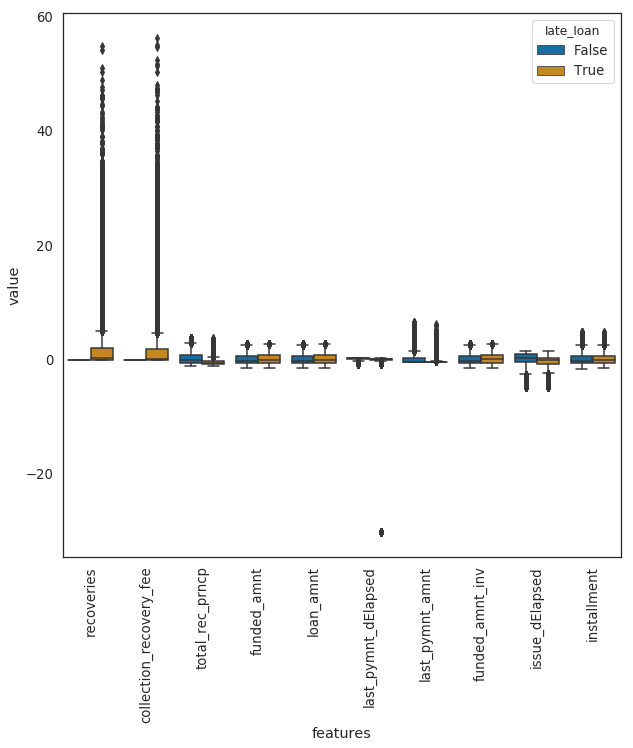

In [38]:
data_dia = y
data = df_keep[top]
data_n_2 = (data - data.mean()) / (data.std())              # standardization
data = pd.concat([pd.Series(y).rename("late_loan"), data_n_2.iloc[:,0:10]],axis=1)
data = pd.melt(data, id_vars="late_loan",
                    var_name="features",
                    value_name='value')

plt.figure(figsize=(10,10))
sns.boxplot(x="features", y="value", hue="late_loan", data=data)
plt.xticks(rotation=90)

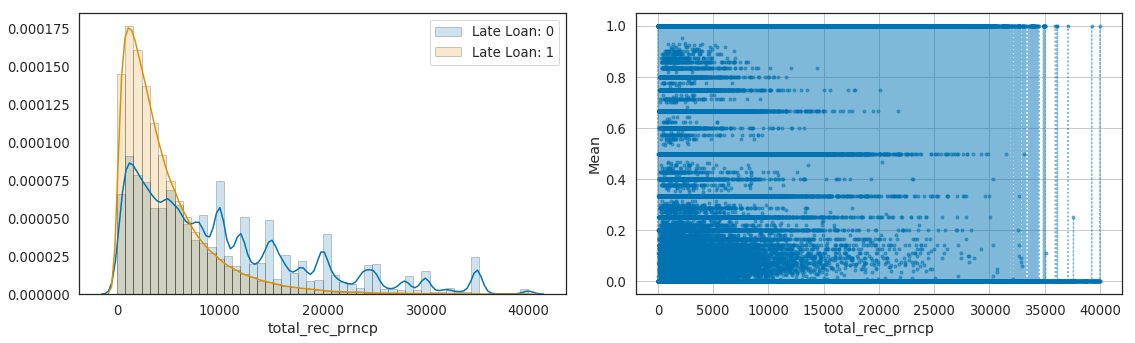

In [39]:
feature = 'total_rec_prncp'
fig, ax = plot_numerical(df_raw, feature=feature, figsize=(16, 5))
plt.show()

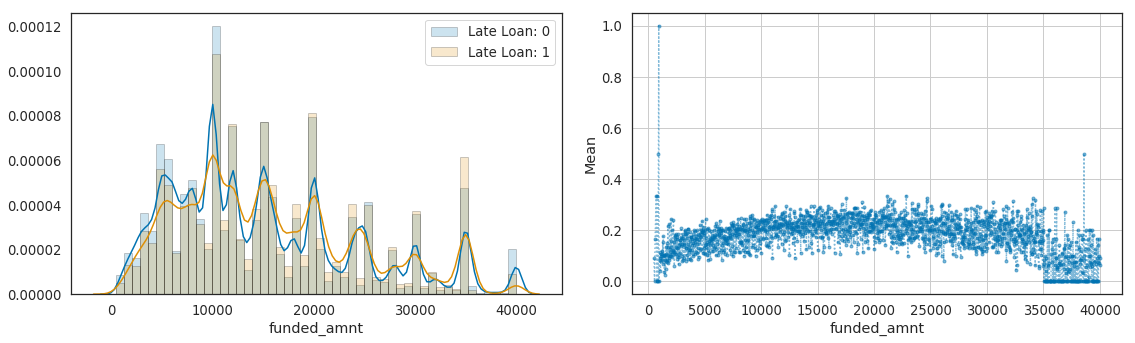

In [40]:
feature = 'funded_amnt'
fig, ax = plot_numerical(df_raw, feature=feature, figsize=(16, 5))
plt.show()

#### How's about not in the top list features?

In [41]:
purpose_condition = round(pd.crosstab(y, df_raw.purpose).apply(lambda x: x/x.sum() * 100), 2)

purpose_bad_loans = purpose_condition.values[0].tolist()
purpose_good_loans = purpose_condition.values[1].tolist()
purpose = purpose_condition.columns


bad_plot = go.Bar(
    x=purpose,
    y=purpose_bad_loans,
    name = 'Late Loans',
    text='%',
    marker=dict(
        color='rgba(219, 64, 82, 0.7)',
        line = dict(
            color='rgba(219, 64, 82, 1.0)',
            width=2
        )
    )
)

good_plot = go.Bar(
    x=purpose,
    y=purpose_good_loans,
    name='Paid And Current Loans',
    text='%',
    marker=dict(
        color='rgba(50, 171, 96, 0.7)',
        line = dict(
            color='rgba(50, 171, 96, 1.0)',
            width=2
        )
    )
)


data = [bad_plot, good_plot]

layout = go.Layout(
    title='Condition of Loan by Purpose',
    xaxis=dict(
        title=''
    ),
    yaxis=dict(
        title='% of the Loan',
    ),
    paper_bgcolor='#FFF8DC',
    plot_bgcolor='#FFF8DC',
    showlegend=True
)

fig = dict(data=data, layout=layout)
iplot(fig, filename='condition_purposes')

In [43]:
# late loan ratio by addr_state
state_rate = df_raw.groupby('addr_state')['late_loan'].mean().reset_index()
state_rate = state_rate.sort_values(by='late_loan', ascending=False)


scl = [[0.0, 'rgb(242,240,247)'], [0.2, 'rgb(218,218,235)'], 
       [0.4, 'rgb(188,189,220)'], [0.6, 'rgb(158,154,200)'],
       [0.8, 'rgb(117,107,177)'], [1.0, 'rgb(84,39,143)']]

data = [dict(type='choropleth', colorscale=scl, autocolorscale=False,
        locations=state_rate['addr_state'], z=state_rate['late_loan'],
        locationmode='USA-states', colorbar=dict(title='Default Rate'),
        marker=dict(line=dict(color = 'rgb(255,255,255)', width=2)))]

geo = dict(scope='usa', projection=dict(type='albers usa'), 
           showlakes=True, lakecolor='rgb(255, 255, 255)')

layout = dict(title='Late Loann Rate Distribution by State', geo=geo, 
              margin=go.Margin(l=50, r=50, b=50, t=40, pad=4), 
              width=1000, height=600)
    
fig = dict(data=data, layout=layout)
iplot(fig)
